In [1]:
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

## Define Compute Loss Density function (DMR44 magnetic material)

In [2]:
# Loss data for DMR44
## Data for 100 kHz and 25°C
data_100k_25C_x = [50.43988739093397, 81.06823664212065, 153.55415016812432, 296.20911241965206]
data_100k_25C_y = [26.941434246171102, 79.9673347137438, 329.4574652351894, 1440.70827878885]

## Data for 100 kHz and 100°C
data_100k_100C_x = [50.74767107013431, 93.24314401826693, 161.21209514454034, 296.20911241965206]
data_100k_100C_y = [6.3472995818200415, 33.19216637405551, 161.78532101352494, 840.0301178252122]

## Data for 200 kHz and 25°C
data_200k_25C_x = [50.74767107013431, 89.90107011797573, 166.19106151917026, 298.0165774071646]
data_200k_25C_y = [72.04522101505854, 271.429444531243, 1069.3656104673032, 3969.2230216707258]

## Data for 200 kHz and 100°C
data_200k_100C_x = [49.52769134960666, 96.70945957597505, 174.47922568335946, 262.2758216661127]
data_200k_100C_y = [27.345961868755982, 140.88582968667282, 625.3404255629255, 1748.7126295116889]

def compute_loss_density(flux_density: float, frequency: float, temperature: float):
    
    if flux_density <= 0 or frequency <= 0 or temperature < 0:
        return 0
    else:
        # Create interpolators for each dataset
        interp_100k_25C = interp1d(np.log10(data_100k_25C_x), np.log10(data_100k_25C_y), kind='linear', fill_value='extrapolate')
        interp_100k_100C = interp1d(np.log10(data_100k_100C_x), np.log10(data_100k_100C_y), kind='linear', fill_value='extrapolate')
        interp_200k_25C = interp1d(np.log10(data_200k_25C_x), np.log10(data_200k_25C_y), kind='linear', fill_value='extrapolate')
        interp_200k_100C = interp1d(np.log10(data_200k_100C_x), np.log10(data_200k_100C_y), kind='linear', fill_value='extrapolate')
    
        # Compute losses for the given flux density from each interpolator
        y_100k_25C = interp_100k_25C(np.log10(flux_density))
        y_100k_100C = interp_100k_100C(np.log10(flux_density))
        y_200k_25C = interp_200k_25C(np.log10(flux_density))
        y_200k_100C = interp_200k_100C(np.log10(flux_density))
    
        # Interpolate over temperature for each frequency
        temperatures = [25, 100]
        y_100k_T = np.interp(temperature, temperatures, [y_100k_25C, y_100k_100C])
        y_200k_T = np.interp(temperature, temperatures, [y_200k_25C, y_200k_100C])
    
        # Interpolate over frequency
        frequencies = [100e3, 200e3]  # Frequencies in Hz
        interp_loss_density = 10**(np.interp(np.log10(frequency), np.log10(frequencies), [y_100k_T, y_200k_T]))
        
        return max(interp_loss_density, 0)

## Check computation of loss densities

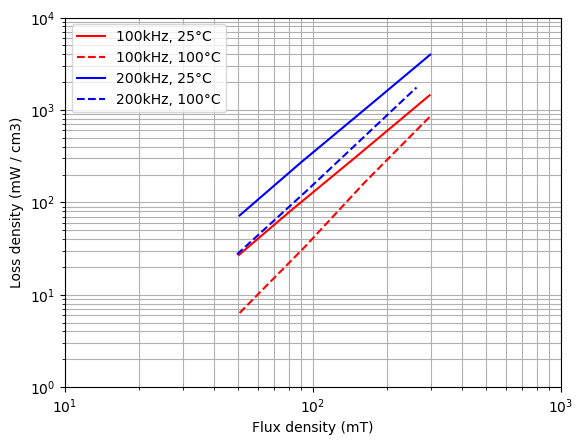

The interpolated loss density at:
 - B = 200 mT,
 - frequency = 100 kHz,
 - temperature = 100°C,
is 290 mW / cm3

The interpolated loss density at:
 - B = 0 mT,
 - frequency = 300 kHz,
 - temperature = 60°C,
is 0 mW / cm3


In [3]:
## Plot loss data
#plt.figure(figsize=(8, 6))
plt.loglog(data_100k_25C_x, data_100k_25C_y, 'r', label = '100kHz, 25°C')
plt.loglog(data_100k_100C_x, data_100k_100C_y, 'r--', label = '100kHz, 100°C')
plt.loglog(data_200k_25C_x, data_200k_25C_y, 'b', label = '200kHz, 25°C')
plt.loglog(data_200k_100C_x, data_200k_100C_y, 'b--', label = '200kHz, 100°C')
plt.xlabel('Flux density (mT)')
plt.ylabel('Loss density (mW / cm3)')
plt.xlim(10, 1000)
plt.ylim(1, 1e4)
plt.grid(which='both')
plt.legend()
plt.show()

flux_density = 200  # flux_density 200 mT
frequency = 100e3  # Frequency 150 kHz
temperature = 100  # Temperature 60°C
print(f"The interpolated loss density at:\n - B = {flux_density} mT,\n - frequency = {frequency/1e3:0.0f} kHz,\n - temperature = {temperature}°C,\nis {compute_loss_density(flux_density, frequency, temperature):0.0f} mW / cm3\n")

flux_density = 0  # flux_density 100 mT
frequency = 300e3  # Frequency 150 kHz
temperature = 60  # Temperature 60°C
print(f"The interpolated loss density at:\n - B = {flux_density} mT,\n - frequency = {frequency/1e3:0.0f} kHz,\n - temperature = {temperature}°C,\nis {compute_loss_density(flux_density, frequency, temperature):0.0f} mW / cm3")

## Compute core volume and equivalent magnetizing inductor of transformer

In [4]:
# Compute transformer volume based on 2 E-core E64/18/50
base = 64 * 50 * 9 
legs = 2 * (18 * 50 * 9)                    # 1 central leg and 2 side legs equivalent to 2 central legs
single_ecore_volume = base + legs           # volume of 1 e-core (mm3)
core_volume = 2 * single_ecore_volume       # volume of 2 e-cores (mm3)
print(f'Core volume: {core_volume / 1e3 :0.1f} cm3')

# Compute equivalent magnetizing inductor
Ac = 0.000516                               # core section m²
Le = 0.112                                  # magnetic path length (m)
ur = np.array([2400, 2200])                  # relative permeability µi and µe
uo = 4 * np.pi * 1e-7
R = Le / Ac / (uo * ur)
Npri = 24
Lm = Npri**2 / R
print(f'Magnetizing inductor: {Lm[0] * 1e3:.2f} mH for µe = µi = {ur[0]}')
print(f'Magnetizing inductor: {Lm[1] * 1e3:.2f} mH for µe = {ur[1]}')


Core volume: 90.0 cm3
Magnetizing inductor: 8.00 mH for µe = µi = 2400
Magnetizing inductor: 7.34 mH for µe = 2200


## Simulate DAB converter models in Simba

In [5]:
def steadystate_signal(horizon_time: float, *signals):
    timepoints_list = []
    for signal in signals:
        timepoints_list.extend(signal.TimePoints)
    timepoints = sorted(timepoints_list)
    steadystate_maskarray = np.array(timepoints) > (timepoints[-1] - horizon_time)
    steadystate_time = np.array(timepoints)[steadystate_maskarray]
    steadystate_datapoints_list = [np.interp(steadystate_time, signal.TimePoints, signal.DataPoints) for signal in signals]
    return steadystate_time, *steadystate_datapoints_list

def str_to_float(s):
    mapping = {
        'k': 1e3,
        'm': 1e-3,
        'M': 1e6
    }
    if s[-1] in mapping:
        return float(s[:-1]) * mapping[s[-1]]
    return float(s)

In [ ]:
# For unit tests only
if os.environ.get("SIMBA_SCRIPT_TEST"):
    endtime = 0.01
    print("Running in test mode")
else:
    endtime = 0.5

from aesim.simba import ProjectRepository
notebook_folder = os.getcwd()
project = ProjectRepository(os.path.join(notebook_folder, 'dual_active_bridge_ti.jsimba'))

# From the electrical model of the transformer
design_elec = project.GetDesignByName('1- ElectroThermal Model - OpenLoop')
design_elec.Circuit.GetDeviceByName('Lm').Value = float(np.format_float_scientific(Lm[0], precision=3))
design_elec.Circuit.GetDeviceByName('PhaseShift').Value = 23
design_elec.TransientAnalysis.CompressScopes = True
design_elec.TransientAnalysis.TimeStep = 2e-9
design_elec.TransientAnalysis.EndTime = endtime
job = design_elec.TransientAnalysis.NewJob()
status = job.Run()
if str(status) != "OK": 
    raise Exception(job.Summary())

# Get electrical waveforms in steady state
signal_iLm = job.GetSignalByName('Lm - Current')
signal_iPri = job.GetSignalByName('Llk - Current')
signal_iSec = job.GetSignalByName('Rsec - Current')
fsw = str_to_float(design_elec.Circuit.GetVariableValue("fsw"))
time_elec, iLm, iPri, iSec = steadystate_signal(1 / fsw, signal_iLm, signal_iPri, signal_iSec)
flux_estimated = iLm * Lm[0] / Npri

# Get powerswitch losses and jucntion temperatures
powerswitch_loss = job.GetSignalByName('Heat Flow - Heat Flow').DataPoints[-1]
Tj_T1 = job.GetSignalByName('T1 - Junction Temperature (°)')
Tj_D1 = job.GetSignalByName('D1 - Junction Temperature (°)')
Tj_T5 = job.GetSignalByName('T5 - Junction Temperature (°)')
Tj_D5 = job.GetSignalByName('D5 - Junction Temperature (°)')

# From the magnetic model of the transformer
design_mag = project.GetDesignByName('2- ElectroMagnetoThermal Model - OpenLoop')
design_mag.TransientAnalysis.CompressScopes = True
design_mag.TransientAnalysis.TimeStep = 2e-9
design_mag.TransientAnalysis.EndTime = endtime
job_mag = design_mag.TransientAnalysis.NewJob()
if str(job_mag.Run()) != "OK": 
    raise Exception(job_mag.Summary())
signal_flux = job_mag.GetSignalByName('flux - Out')
time_mag, flux = steadystate_signal(1 / fsw, signal_flux)



Design Loaded: 2- ElectroMagnetoThermal Model - OpenLoop


## Powerswitch Losses

Total Powerswitch Loss: 126.39 W


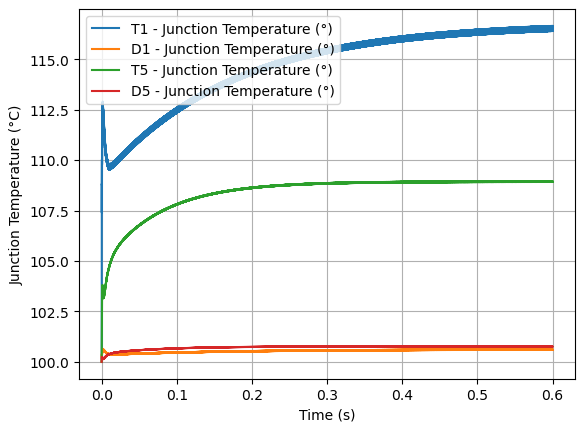

In [7]:
plt.figure()
for signal in [Tj_T1, Tj_D1, Tj_T5, Tj_D5]:
    plt.plot(signal.TimePoints, signal.DataPoints, label=signal.Name)
plt.xlabel('Time (s)')
plt.ylabel('Junction Temperature (°C)')
plt.legend(loc='upper left')
plt.grid(True)
print(f"Total Powerswitch Loss: {powerswitch_loss:.2f} W")


## DC Copper Losses

In [8]:
def compute_rms(time, data):
    """ compute rms value of a given signal in steady state """
    dt = np.diff(time)
    squared_data = data[:-1] ** 2
    rms_value = np.sqrt(np.sum(squared_data * dt) / np.sum(dt))
    return rms_value

iPri_rms = compute_rms(time_elec, iPri)
iSec_rms = compute_rms(time_elec, iSec)

dcLoss_inductor = iPri_rms ** 2 * design_elec.Circuit.GetDeviceByName('Rlk').Value
dcLoss_pri = iPri_rms ** 2 * design_elec.Circuit.GetDeviceByName('Rpri').Value
dcLoss_sec = iSec_rms ** 2 * design_elec.Circuit.GetDeviceByName('Rsec').Value

print(f"Primary RMS current: {iPri_rms:.2f} A")
print(f"Secondary RMS current: {iSec_rms:.2f} A")
print(f"Inductor DC loss: {dcLoss_inductor:.2f} W")
print(f"Primary DC loss: {dcLoss_pri:.2f} W")
print(f"Secondary DC loss: {dcLoss_sec:.2f} W")


Primary RMS current: 14.01 A
Secondary RMS current: 22.51 A
Inductor DC loss: 4.52 W
Primary DC loss: 8.45 W
Secondary DC loss: 8.11 W


## Core Magnetic Losses

In [9]:
def compute_fft(time, signal, fstep):
    N = 10000
    time_resamp = np.linspace(time[0], time[-1], N, endpoint=False)
    signal_resamp = np.interp(time_resamp, time, signal)
    freqs = np.fft.rfftfreq(N) * fstep * len(signal_resamp)
    fft = np.abs(np.fft.rfft(signal_resamp) / len(signal_resamp))
    fft[1:] = 2 * fft[1:]
    return freqs, fft

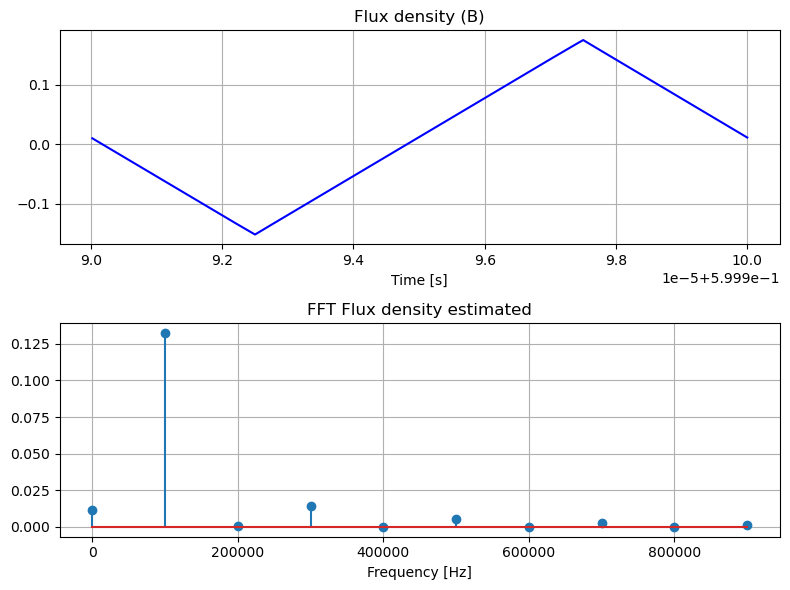

In [10]:
# Compute FFT of the flux density estimated from the electrical model of the transformer
flux_density_estimated = flux_estimated / Ac
freqs, fft_flux_densities_estimated = compute_fft(time_elec, flux_density_estimated, fsw)
max_index = 10
freqs = freqs[:max_index]
fft_flux_densities_estimated = fft_flux_densities_estimated[:max_index]

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(time_elec, flux_density_estimated, color='blue', linestyle='-', linewidth=1.5, label='Signal')
plt.title('Flux density (B)')
plt.xlabel('Time [s]')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.stem(freqs, fft_flux_densities_estimated)
plt.title('FFT Flux density estimated')
plt.xlabel('Frequency [Hz]')
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Compute FFT of the flux density from the magnetic model of the transformer
flux_density = flux / Ac
freqs, fft_flux_densities = compute_fft(time_mag, flux_density, fsw)
max_index = 10
freqs = freqs[:max_index]
fft_flux_densities = fft_flux_densities[:max_index]

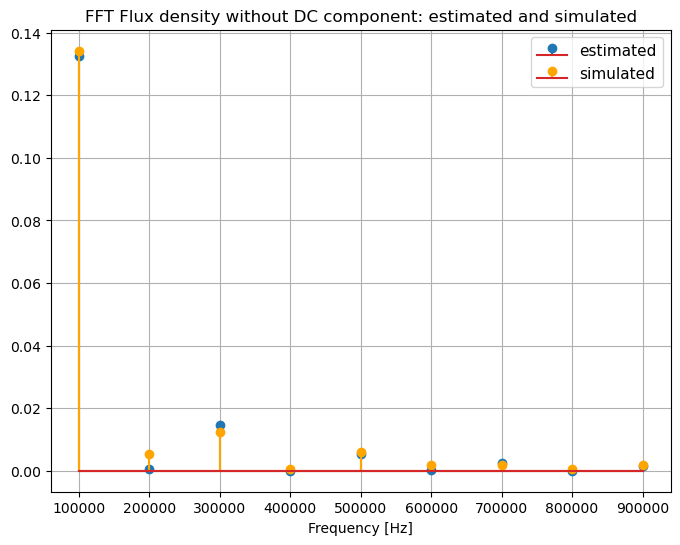

In [12]:
# Display on the same graph results obtained with electrical and magnetic models
plt.figure(figsize=(8, 6))
plt.stem(freqs[1:], fft_flux_densities_estimated[1:], label='estimated')
plt.stem(freqs[1:], fft_flux_densities[1:], 'orange', markerfmt='orange', label='simulated')
plt.legend()
plt.title('FFT Flux density without DC component: estimated and simulated')
plt.xlabel('Frequency [Hz]')
plt.grid(True)
plt.legend(fontsize=11)

In [13]:
temperature = 100

# Compute Core Loss with fft of flux density
total_loss_density = 0
print(f"\n--- Core Loss computation with FFT of flux density method ---")
for freq, fft_flux_density_estimated in zip(freqs, fft_flux_densities_estimated):
    total_loss_density += compute_loss_density(fft_flux_density_estimated*1e3, freq, temperature)
    if fft_flux_density_estimated * 1e3 >= 1:
        print(f"Loss density at {temperature}°C, {freq/1e3:0.0f} kHz, {fft_flux_density_estimated*1e3:0.0f} mT is {compute_loss_density(fft_flux_density_estimated*1e3, freq, temperature):0.2f} mW / cm3")
print(f"Total Loss density at {temperature}°C: {total_loss_density : 0.1f} mW / cm3")
print(f"Total Core Loss (FFT) at {temperature}°C: {total_loss_density * core_volume / 1e6 : 0.1f} W")

# Compute core loss from maximum flux density
print(f"\n--- Core Loss computation with max flux density method ---")
flux_density_estimated_max = np.max(flux_density_estimated) - fft_flux_densities_estimated[0]
print(f"Estimated maximum flux density: {flux_density_estimated_max*1e3:.0f} mT")
print(f'Theoretical maximum flux density: {500 / 15 / Ac / 4 / fsw*1e3:.0f} mT (for comparison)')
print(f"Total Core Loss (max flux density) at {temperature}°C : {compute_loss_density(flux_density_estimated_max*1e3, fsw, temperature) * core_volume / 1e6 : 0.1f} W")


--- Core Loss computation with FFT of flux density method ---
Loss density at 100°C, 0 kHz, 11 mT is 0.00 mW / cm3
Loss density at 100°C, 100 kHz, 133 mT is 92.00 mW / cm3
Loss density at 100°C, 300 kHz, 15 mT is 1.35 mW / cm3
Loss density at 100°C, 500 kHz, 5 mT is 0.12 mW / cm3
Loss density at 100°C, 700 kHz, 3 mT is 0.02 mW / cm3
Loss density at 100°C, 900 kHz, 2 mT is 0.01 mW / cm3
Total Loss density at 100°C:  93.5 mW / cm3
Total Core Loss (FFT) at 100°C:  8.4 W

--- Core Loss computation with max flux density method ---
Estimated maximum flux density: 163 mT
Theoretical maximum flux density: 161 mT (for comparison)
Total Core Loss (max flux density) at 100°C :  15.1 W


## Estimation of efficiency and Loss coefficient

In [14]:
efficiency = 1e4 / (1e4 + dcLoss_inductor + dcLoss_pri + dcLoss_sec + powerswitch_loss)
print(f"Efficiency: {efficiency * 100:.2f}%")
loss_coeff = 1 - efficiency
print(f"Loss coefficient: {loss_coeff * 100:.2f}%")


Efficiency: 98.55%
Loss coefficient: 1.45%
